# We make up a toy problem to gain intuition about attenion heads

Let's use the following list of words (and a special token):
<Start>, the, man, chicken, ordered,woman, beef    7 words,so V=7, and token ids are 1 to 7

This our corpus:  

<Start> man ordered the chicken

<Start> woman ordered the beef

Exercise Goal:
Let's examine the Attention Wt matrix and Output predictions (see end of notebook) to see how dependencies might be encoded  

Look at the output prediction of "the -> chckn" or "the ->beef"
Look at the 4th row (b/c 'the' is 4th input token) of the TxT attention weights.
Look at the Q,K matrices to see what values are asymmetric between the two input cases


In [1]:
# ----------- IMPORT STATEMENTS ---------------
import argparse
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
import os
import sys
import numpy as np
import time

#---------------------------------------------
print('import done')
#import pandas as pd
np.set_printoptions(precision=4)

#set the embedding/attention head size parameters
E = 7  #size of embedding layer, which in this notebook is same as V, size of vocabulary

H = 20  #size of attention head    #<<<<<<<<<---- try 10,20,40 ---
                                     # How does H parameter affect the Attent. Wts?  hint: look at model summary output


import done


In [2]:
epochs         = 5000
lrate          = 0.0001
torch.manual_seed(77)


## Set up sequence input


In [3]:
# Set up sequence input
if 1:
    colnames  =  ["<ST>", "the", "man","chkn","ordrd","woman","beef"]
    V    = len(colnames)
    #------ make a sequence of length T --------------
    sequence2use   = np.asarray([[1,3,5,2,4],[1,6,5,2,7]])  #start is first token, with array index 0,
    B,T            = sequence2use.shape
    sequence2pred  = np.zeros((B,T),dtype=int)
    for bi in range(B):
      sequence2pred[bi,0:-1] = sequence2use[bi,1:]
      sequence2pred[bi,-1]   = sequence2use[bi,0]

#set up a dataframe info for nice printouts later
rownamesxb =list(list())
for bi in range(B):
    rownames=list()
    for i in range(T):
        rownames.append(str(i)+' '+colnames[sequence2use[bi,i]-1])
    rownamesxb.append(rownames)

print('--- Input Sequences (start at 1..T): -----')
print(sequence2use)
print('--- Target Sequences: -----')
print(sequence2pred)
print(sequence2pred.shape)


--- Input Sequences (start at 1..T): -----
[[1 3 5 2 4]
 [1 6 5 2 7]]
--- Target Sequences: -----
[[3 5 2 4 1]
 [6 5 2 7 1]]
(2, 5)


## Now set up training data (X input and Y targets, and also positions)  
 training data are sequences of token id numbers, but start at 0 to get indexing right


In [4]:
#Now set up training data  Batch size is just 1
#B is 2 (b/c 2 sequences in training data)
#set up token sequences of id numbers AS column vectors
# so that each id indicates which unit is on in a one-hot vector

#Xtrain converts input sequence of ids (but start at 0 )
#Xtrain  = np.zeros((B,T,1)) #sequence2use.copy()
Xtrain  = np.zeros((B,T)) #sequence2use.copy()
for bi in range(B):
    for ti in range(T):
       Xtrain[bi,ti]=sequence2use[bi,ti]-1  #Xtrain_ids[bi,ti]-1  #index starts at 0 so subtract1

#make position information same size as X train
#Postrain=np.zeros((B,T,1))
Postrain=np.zeros((B,T))
for bi in range(B):
  #Postrain[bi,:,0] = np.arange(T)  #set Position to integer 1...T
  Postrain[bi,:] = np.arange(T)  #set Position to integer 1...T
print(Postrain.shape)

# make target values as the index
Ytrain=sequence2pred.copy()
for bi in range(B):
   for ti in range(T):
      Ytrain[bi,ti]=Ytrain[bi,ti]-1  #index starts at 0 so subtract1
#Ytrain = tf.expand_dims(Ytrain,axis=2)
#Ytrain = Ytrain[:,:,np.newaxis] #(Ytrain,axis=2)
print(Ytrain.shape)
print(Ytrain)

#make one hot vector of each id
def make1hot(M):
  Xtmp=np.zeros((2,T,V))  
  for i in range(2):
    for j in range(T):
      #print(M[i,j,0])
      Xtmp[i,j,int(M[i,j,0])]=1
  return Xtmp
if 0:
  Xtrain=make1hot(Xtrain)
  Ytrain=make1hot(Ytrain)


(2, 5)
(2, 5)
[[2 4 1 3 0]
 [5 4 1 6 0]]


In [5]:
Postrain
#Xtrain[0,]

array([[0., 1., 2., 3., 4.],
       [0., 1., 2., 3., 4.]])

## Now set up scaled-dot product constants and attention mask

In [6]:
#Now set up model related values
scale_value    = np.divide(1,np.sqrt(H)) #use H b/c it's dimension of Qmat, Kmat

#Make a mask
Mskl=torch.tril(torch.ones(T,T))
Msklbool=Mskl.bool()
print('scaling setup, causal Mask set up')


scaling setup, causal Mask set up


## Now build model layers that will learn transformation for Q,K,V matrices

In [18]:
#Now build model to learn transformation for Q,K,V matrices
class MyNet(torch.nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.Xembed    =  torch.nn.Embedding(V,E)
        self.Pos_Input =  torch.arange(T) #position info is just 1...T
        self.Pos_Embed =  torch.nn.Embedding(T,E)

        #now feed to Q,K,V transformations
        #<<<<------------------- H embedding size is used here Q,K
        self.Qmat       = torch.nn.Linear(E,H,bias=False)
        self.Kmat       = torch.nn.Linear(E,H,bias=False)
        self.Vmat       = torch.nn.Linear(E,V,bias=False)
        self.Smax       = torch.nn.Softmax(dim=-1) #apply softmax functional
        self.Smax2      = torch.nn.Softmax(dim=-1) #apply softmax functional
        self.Sigout     = torch.nn.Sigmoid()     #final output between 0,1
    def forward(self, x):
        xembed   = self.Xembed(x)
        posembed = self.Pos_Embed(self.Pos_Input.to(device))
        Xinputs  = xembed+posembed       #<<<--- comment out +Posembed see if it learns
        #print(' Xinptsshp:',Xinputs.shape)

        Q  = self.Qmat(Xinputs)
        K  = self.Kmat(Xinputs)
        V  = self.Vmat(Xinputs)
        QK = Q @ K.transpose(-2, -1) * scale_value #matrix multiplcation
        QKmasked = QK.masked_fill(~Msklbool.to(device), float('-inf')) # Mask out lower triangular with -inf

        Attn_Wts_smx = self.Smax(QKmasked)                   
        Attn_Wts     = torch.mul(Attn_Wts_smx,Mskl.to(device))         #elemnt wise x Mask
        Vout         = Attn_Wts @ V
        
        #<<< A full transformer would have a MLP hidden layer here, of a softmax, but we just squash it all to 0,1
        if 1: #use positional, inputs, info  
          VoutandXinput  = Vout+ Xinputs #skip connnection with add
          Prob_output    = self.Smax2(VoutandXinput)
        if 0: #experiment , no positional input info
          Prob_output    = self.Smax2(Vout) #andXinput)
        return Prob_output 
        


In [19]:
# --------------------------------------------------------
#   Define training function
# --------------------------------------------------------

def train(model, device, optimizer, epoch):
    ''' This is called for each epoch.  
        Arguments:  the model, the device to run on, data loader, optimizer, and current epoch
    ''' 
    model.train()
    totloss=0
    for i in range(2):
        data,target = Xtrain[i],Ytrain[i]
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()                 #reset optimizer state
        output = model(data)                  #get predictions
        
        #if output is softmax, use log before nll
        loss = F.nll_loss(torch.log(output), target)     #get loss (nll_loss for softmax outputs)

        #if output is -1 to 1(logits) ,crossent will take log-softmax
        #loss = F.CrossEntropy(output, target)     #get loss (nll_loss for softmax outputs)
        loss.backward()                       #backprop loss
        optimizer.step()                      #update weights
    totloss +=loss
    if (epoch % 100 ==0):
          print('.... loss:',totloss)
        
def get_activation(name, activation):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
    
print('Train,test, support functions defined ')

Train,test, support functions defined 


In [20]:
# -------------------------------------------------
#  Get device  
#  (note, this is set up for 1 GPU device
#    if this were to run on a full GPU node with >1 gpu device, you would
#     want to get rank, world size info and set device id 
#     as in:   torch.cuda.set_device(local_rank) 
#     and then also run distributed initialization )
# -------------------------------------------------
use_cuda = torch.cuda.is_available() 
if use_cuda:
        num_gpu = torch.cuda.device_count()
        print('INFO,  cuda, num gpu:',num_gpu)
        device     = torch.cuda.current_device()
        print('environ visdevs:',os.environ["CUDA_VISIBLE_DEVICES"])
else:
        num_gpu = 0
        print('INFO, cuda not available')
        device  = torch.device("cpu")   
print('INFO, device is:', device)

INFO,  cuda, num gpu: 1
environ visdevs: 0
INFO, device is: 0


In [21]:
mymodel = MyNet().to(device)


In [22]:
# -------------------------------------------
#  Do training loop
# -------------------------------------------

# Dictionary to store activations
activations = {}
# Register hooks
mymodel.Qmat.register_forward_hook(get_activation('Qmat', activations))
mymodel.Kmat.register_forward_hook(get_activation('Kmat', activations))
mymodel.Vmat.register_forward_hook(get_activation('Vmat', activations))
mymodel.Smax.register_forward_hook(get_activation('Smax', activations))
mymodel.Smax2.register_forward_hook(get_activation('Smax2', activations))

optimizer = torch.optim.Adam(mymodel.parameters(), lr=lrate)

Xtrain=torch.tensor(Xtrain,dtype=int).to(device)
Ytrain=torch.tensor(Ytrain,dtype=int).to(device)
train_results = []
test_results  = []
for epoch in range(epochs):
        if (epoch % 100==0):
          print('INFO about to train epoch:',epoch)
        train(mymodel, device, optimizer, epoch)

print('INFO  done');


/scratch/etrain107/job_40600820/ipykernel_1568145/44505167.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtrain=torch.tensor(Xtrain,dtype=int).to(device)
/scratch/etrain107/job_40600820/ipykernel_1568145/44505167.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Ytrain=torch.tensor(Ytrain,dtype=int).to(device)


INFO about to train epoch: 0
.... loss: tensor(3.1632, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train epoch: 100
.... loss: tensor(3.0198, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train epoch: 200
.... loss: tensor(2.8617, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train epoch: 300
.... loss: tensor(2.6861, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train epoch: 400
.... loss: tensor(2.5046, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train epoch: 500
.... loss: tensor(2.3337, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train epoch: 600
.... loss: tensor(2.1789, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train epoch: 700
.... loss: tensor(2.0397, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train epoch: 800
.... loss: tensor(1.9144, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train epoch: 900
.... loss: tensor(1.8008, device='cuda:0', grad_fn=<AddBackward0>)
INFO about to train ep

In [23]:
with torch.no_grad():
 PredOutput=[];Attn_Wts=[];Vmat=[]
 for i in range(B):
    data,target = Xtrain[i],Ytrain[i]
    data, target = data.to(device), target.to(device)
    output = mymodel(data)                  #get predictions
    #Q = np.squeeze(activations['Qmat'].detach().cpu())
    #K = np.squeeze(activations['Kmat'].detach().cpu())
    Vmat.append(np.squeeze(activations['Vmat'].detach().cpu()))
    Attn_Wts_smx=np.squeeze(activations['Smax'].detach().cpu())
    Attn_Wts.append(torch.mul(Attn_Wts_smx,Mskl))
    PredOutput.append(np.squeeze(activations['Smax2'].detach().cpu())) #



In [24]:
# -------------------------------------------

## Now we want to examine the Outputs and Attention Wt matrix see how those matrices affect the 'the' predictions for each input sequence



In [14]:
# Helper functions to plot heat map
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    if ax is None:
        ax = plt.gca()
    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im #, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

 ---------- Output Predictions TxV (t-th row are predictions at time t) --


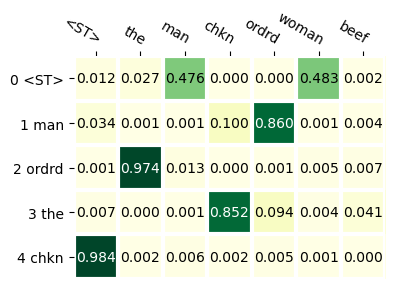

 ---------- Output Predictions TxV (t-th row are predictions at time t) --


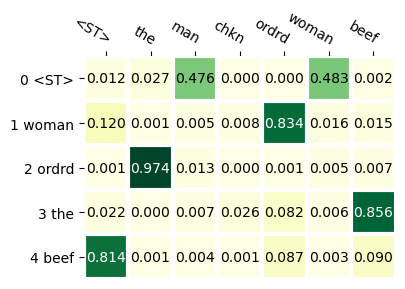

In [15]:
#OUTPUT 
Final_Pout_pred = PredOutput
#np.array(Out)#.detach().cpu()) #my_actvtns_output[layernum2get]

#Final_pred =my_attn_model.predict([Xtrain,Postrain])

for bi in range(B):
  print(' ---------- Output Predictions TxV (t-th row are predictions at time t) --')
  fig, ax = plt.subplots(figsize=(5,3))
  im = heatmap(Final_Pout_pred[bi],rownamesxb[bi], colnames,ax=ax,cmap="YlGn")
  texts = annotate_heatmap(im, valfmt="{x:.3f}")
  fig.tight_layout()
  plt.show()


---  Note, the head size H was:  20
 ----------- Attention Wts TxT --------------


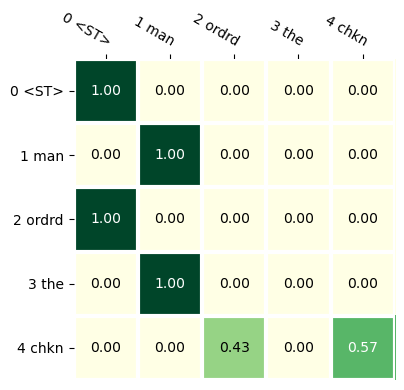

 ----------- Attention Wts TxT --------------


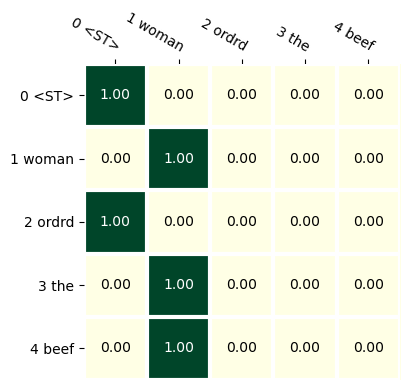

In [16]:
#  <<<<<<< ------------ Can you inteprety how Attn Wts are picking out predictions
AttnW_output = Attn_Wts

print('---  Note, the head size H was: ',H)
for bi in [0,1]:  #bi=0  plt.figure(figsize=(10,6)
  print(' ----------- Attention Wts TxT --------------')
  fig, ax = plt.subplots(figsize=(5,4))
  im = heatmap(AttnW_output[bi],rownamesxb[bi], rownamesxb[bi],ax=ax,cmap="YlGn", cbarlabel="attn wt")
  #im, cbar = heatmap(AttnW_output[bi],rownamesxb[bi], rownamesxb[bi],ax=ax,cmap="YlGn", cbarlabel="attn wt")
  texts = annotate_heatmap(im, valfmt="{x:.2f}")
  fig.tight_layout()
  plt.show()


---  Note, the head size H was:  20
 ----------- Value matrix TxV--------------


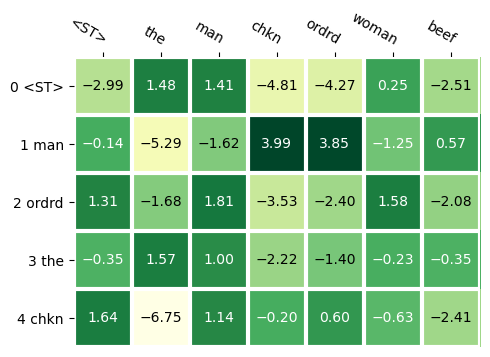

 ----------- Value matrix TxV--------------


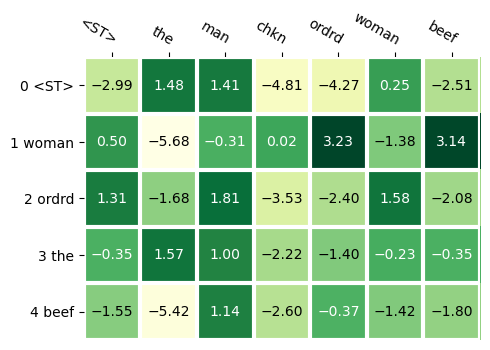

In [17]:
# Here is the Vmat matrix (ie the 'value' matrix )
Vmat_values = Vmat

print('---  Note, the head size H was: ',H)
for bi in [0,1]:
  print(' ----------- Value matrix TxV--------------')
  fig, ax = plt.subplots(figsize=(5,4))
  im = heatmap(Vmat_values[bi],rownamesxb[bi], colnames,ax=ax,cmap="YlGn", cbarlabel="Value matrix")
  texts = annotate_heatmap(im, valfmt="{x:.2f}")
  fig.tight_layout()
  plt.show()
